# Обучение и тестирование моделей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from pathlib import Path

PATH_PROCESSED = Path("../../data/processed")

In [2]:
X_train = pd.read_csv(PATH_PROCESSED / "X_train.csv")
X_test = pd.read_csv(PATH_PROCESSED / "X_test.csv")
y_train = pd.read_csv(PATH_PROCESSED / "y_train.csv").squeeze("columns")
y_test = pd.read_csv(PATH_PROCESSED / "y_test.csv").squeeze("columns")

In [3]:
print("Train size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])
display(X_train.head(2))
display(y_train.head(5))

Train size:  16564
Test size:  4436


year  month  day   fips  humidity_relative  precipitation  \
0  2018     11    1  17001          71.783333       0.187208   
1  2018     11    1  17003          90.355556      18.158111   

   skin_reservoir_content  soil_water_vol_layer1  soil_water_vol_layer2  \
0            4.736086e-07               0.310632               0.317329   
1            3.250581e-04               0.383857               0.324059   

   soil_water_vol_layer3  solar_radiation_downward  temperature_min  \
0               0.258307                444.233333       273.936458   
1               0.241359                 61.733333       278.042667   

   vapor_pressure_deficit  wind_gust  wind_speed  wind_u_component  \
0                0.222625   7.191125    3.372792         -2.079917   
1                0.099333   4.224000    2.226778         -1.714222   

   wind_v_component  
0          2.556042  
1          0.091889

0    197.8
1    188.4
2    194.1
3    187.9
4    214.1
Name: yield_bu_per_acre, dtype: float64

count    535.000000
mean     191.984486
std       23.816835
min      129.000000
25%      174.400000
50%      193.400000
75%      210.700000
max      246.000000
Name: yield_bu_per_acre, dtype: float64

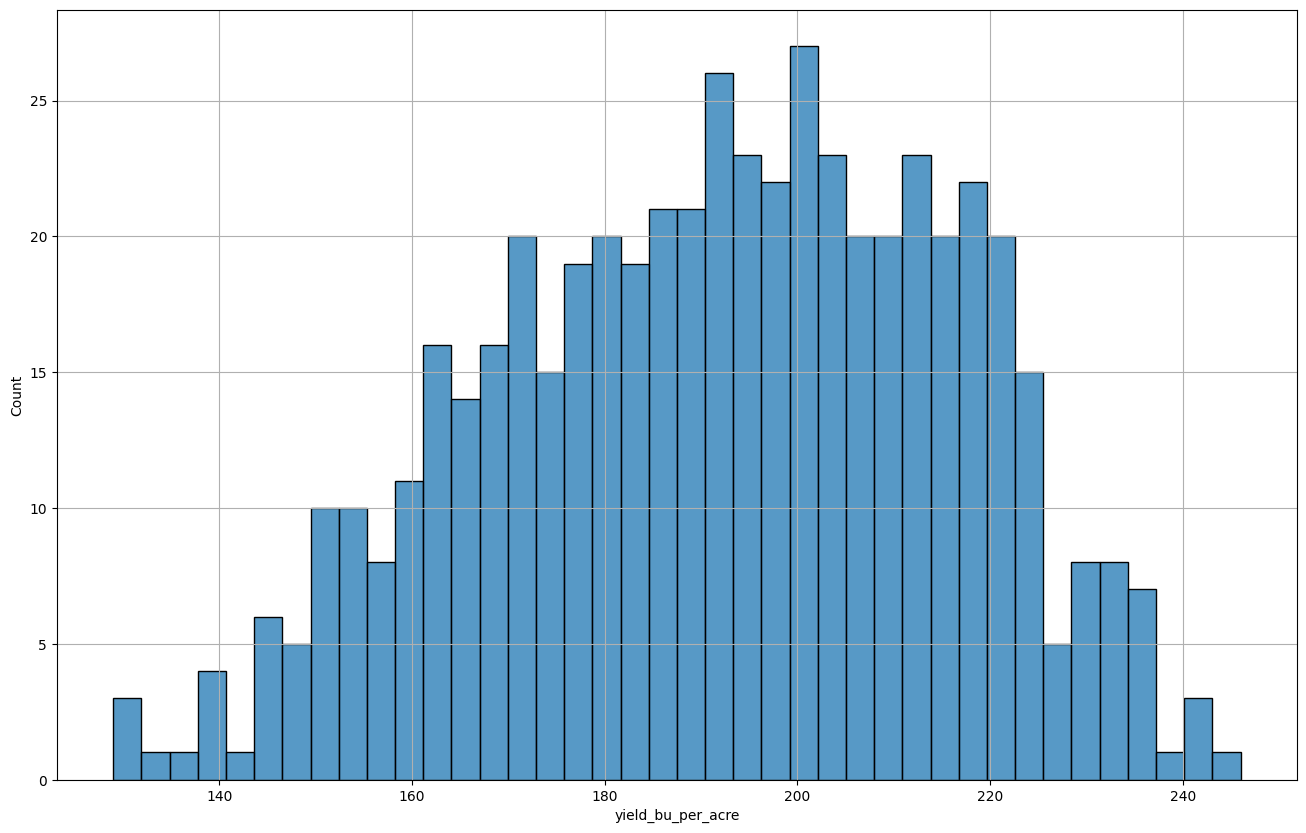

In [4]:
targets = pd.concat([y_train, y_test], ignore_index=True).drop_duplicates()
fig = plt.figure(figsize=(16, 10))
sns.histplot(targets, bins=40)
plt.grid()
display(targets.describe())
plt.show()

In [5]:
def score(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    y_pred_test = model.predict(X_test)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("RMSE Train:", rmse_train)
    print("R^2 Train:", r2_train)
    print("RMSE Test:", rmse_test)
    print("R^2 Test:", r2_test)

***

## 1. Линейная регрессия

### Обучение

Плюсы:
- Простая модель
- 
Минусы:
- Точечная оценка. Т.е. не учитывает динамику изменения параметров. По сути пытается предсказать урожайность, например, по данным за 1-ое января.

Предобработка данных:
- Убираем `year`, `fips`. Т.е. убираем привязку к году и региону.
- `OHE` над `month`, `day`. Чтобы модель могла оценивать важность сезона (мне так кажется).
- `StandardScaler` других признаков. Типичная предобработка для линейной регрессии.

In [6]:
X_train_ridge = X_train.drop(["year", "fips"], axis=1)
X_test_ridge = X_test.drop(["year", "fips"], axis=1)
ridge_preprocessing = ColumnTransformer(
    transformers=[
        ("OHE", OneHotEncoder(), ["month", "day"]),
        (
            "scaler",
            StandardScaler(),
            X_train_ridge.columns.drop(["month", "day"]),
        ),
    ]
)

ridge_model = Pipeline(
    [("preprocessing", ridge_preprocessing), ("model", Ridge(random_state=42))]
)

In [7]:
ridge_model.fit(X_train_ridge, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OHE', OneHotEncoder(),
                                                  ['month', 'day']),
                                                 ('scaler', StandardScaler(),
                                                  Index(['humidity_relative', 'precipitation', 'skin_reservoir_content',
       'soil_water_vol_layer1', 'soil_water_vol_layer2',
       'soil_water_vol_layer3', 'solar_radiation_downward', 'temperature_min',
       'vapor_pressure_deficit', 'wind_gust', 'wind_speed', 'wind_u_component',
       'wind_v_component'],
      dtype='object'))])),
                ('model', Ridge(random_state=42))])

In [8]:
score(ridge_model, X_train_ridge, X_test_ridge, y_train, y_test)

RMSE Train: 19.903784739066225
R^2 Train: 0.06961885825886427
RMSE Test: 24.000834117360768
R^2 Test: -0.24680722724147297


### Выводы

Качество хуже, чем если бы мы предсказывали простым средним значением.

***

## 2. RandomForestRegressor

### Обучение

Плюсы:
- Более сложная модель, для более сложных зависимостей

Минусы:
- Точечная оценка. Т.е. не учитывает динамику изменения параметров. По сути пытается предсказать урожайность, например, по данным за 1-ое января.

Предобработка данных:
- Убираем `year`, `fips`. Т.е. убираем привязку к году и региону.

In [27]:
X_train_forest = X_train.drop(["year", "fips"], axis=1)
X_test_forest = X_test.drop(["year", "fips"], axis=1)
random_forest_model = RandomForestRegressor(
    random_state=42, n_estimators=100, max_depth=4, min_samples_leaf=5
)

In [28]:
random_forest_model.fit(X_train_forest, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=5, random_state=42)

In [29]:
score(random_forest_model, X_train_forest, X_test_forest, y_train, y_test)

RMSE Train: 19.385018299724816
R^2 Train: 0.11748519999224616
RMSE Test: 23.571196407409214
R^2 Test: -0.202568693679261


### Выводы

Модель переобучилась

***

## 3. CatBoost

### Обучение

Плюсы:
- Еще одна сложная модель классического МО

Минусы:
- Точечная оценка. Т.е. не учитывает динамику изменения параметров. По сути пытается предсказать урожайность, например, по данным за 1-ое января.

Предобработка данных:
- Убираем `year`, `fips`. Т.е. убираем привязку к году и региону.

In [12]:
X_train_boosting = X_train.drop(["year", "fips"], axis=1)
X_test_boosting = X_test.drop(["year", "fips"], axis=1)

# Объединяем данные
X = pd.concat([X_train_boosting, X_test_boosting], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

# Правильное определение индексов для кросс-валидации
train_size = len(X_train_boosting)
X_train_index = np.arange(train_size)
X_test_index = np.arange(train_size, len(X))

custom_cv = [(X_train_index, X_test_index)]

params = {
    "depth": [4, 6],
    "learning_rate": [0.001, 0.005, 0.01],
    "iterations": [1000],
    "l2_leaf_reg": [1, 3, 5],
    "grow_policy": ["SymmetricTree", "Depthwise"],
    "min_data_in_leaf": [1, 3],
}

catboost = CatBoostRegressor(random_state=42, verbose=1)
grid_search = GridSearchCV(
    catboost, params, cv=custom_cv, scoring="neg_mean_squared_error"
)

In [13]:
grid_search.fit(X, y)

0:	learn: 20.6338079	total: 50.7ms	remaining: 50.7s
1:	learn: 20.6327049	total: 54.2ms	remaining: 27.1s
2:	learn: 20.6314496	total: 57ms	remaining: 18.9s
3:	learn: 20.6302306	total: 60.2ms	remaining: 15s
4:	learn: 20.6290213	total: 63.1ms	remaining: 12.5s
5:	learn: 20.6278115	total: 65.4ms	remaining: 10.8s
6:	learn: 20.6267027	total: 67.3ms	remaining: 9.54s
7:	learn: 20.6254479	total: 69.1ms	remaining: 8.57s
8:	learn: 20.6242905	total: 71ms	remaining: 7.82s
9:	learn: 20.6231407	total: 72.6ms	remaining: 7.18s
10:	learn: 20.6218337	total: 74.2ms	remaining: 6.67s
11:	learn: 20.6208149	total: 75.8ms	remaining: 6.24s
12:	learn: 20.6197326	total: 77.3ms	remaining: 5.87s
13:	learn: 20.6186002	total: 79.4ms	remaining: 5.59s
14:	learn: 20.6173982	total: 80.9ms	remaining: 5.31s
15:	learn: 20.6162259	total: 82.4ms	remaining: 5.07s
16:	learn: 20.6150597	total: 83.8ms	remaining: 4.84s
17:	learn: 20.6139140	total: 85.1ms	remaining: 4.64s
18:	learn: 20.6126462	total: 86.6ms	remaining: 4.47s
19:	learn

GridSearchCV(cv=[(array([    0,     1,     2, ..., 16561, 16562, 16563], shape=(16564,)),
                  array([16564, 16565, 16566, ..., 20997, 20998, 20999], shape=(4436,)))],
             estimator=<catboost.core.CatBoostRegressor object at 0x7ba4e29db0e0>,
             param_grid={'depth': [4, 6],
                         'grow_policy': ['SymmetricTree', 'Depthwise'],
                         'iterations': [1000], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.001, 0.005, 0.01],
                         'min_data_in_leaf': [1, 3]},
             scoring='neg_mean_squared_error')

In [16]:
grid_search.best_params_

{'depth': 6,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 5,
 'learning_rate': 0.001,
 'min_data_in_leaf': 1}

In [17]:
score(grid_search, X_train_boosting, X_test_boosting, y_train, y_test)

RMSE Train: 19.836026682357733
R^2 Train: 0.07594263182140981
RMSE Test: 21.937030234675287
R^2 Test: -0.041603206229112955


### Выводы

Классическое машинное обучение не способно справится с данной задачей.